In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Data that benefits from sampled hyperparameters

Here's an example where using NUTS for hyperparameter sampling could be useful.

We have a periodic function, but have observed sparse amounts of data. There are many possible period lengths that could explain this data: it could be a slow periodic function, or a fast one.

(Here we're generating some sample data.)

In [2]:
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 2, 7)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.1

/Users/gpleiss/miniconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/gpleiss/miniconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


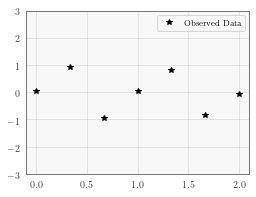

In [3]:
f, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
ax.set_ylim([-3, 3])
ax.legend(['Observed Data'])

## Create the model - w/ batch hyperparameters

We will learn a GP with a **periodic kernel**.
There are several possible period lengths that explain the data.

Here we're going to set the `batch_shape` parameter to have size 2.
This way, our model will learn two sets of hyperparameters for the data.

- The input will be a tensor of the data `n x d` (or in this case, of size `n`).
- The output will be a MultivariateNormal distribution with event shape `n` and batch size `2`.
    - The two batch dimensions correspond to predictions from the model with the different hyperparameter settings.

In [4]:
# This model class takes in a `batch_shape` parameter - which allows us to define batches of hyperparameters

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, batch_shape=torch.Size()):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(
            batch_shape=batch_shape,
        )
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(batch_shape=batch_shape),
            batch_shape=batch_shape
        )
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood, batch_shape=torch.Size([2]))

# Here - we'll do some initializtion of the two period lengths
# so that our optimization finds two different modes
model.covar_module.base_kernel.initialize(period_length=torch.tensor([0.5, 1]))

PeriodicKernel(
  (raw_lengthscale_constraint): Positive()
  (raw_period_length_constraint): Positive()
)

## Optimize the hyperparameters

In [6]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.05)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def train(num_iter=200):
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y).sum()
        loss.backward()
        if (i + 1) % 20 == 0:
            print(f'Iter {i + 1}/{num_iter} - Loss: {loss.item()}')
        optimizer.step()
        
%time train()

Iter 20/200 - Loss: 1.7074110507965088
Iter 40/200 - Loss: 1.2099368572235107
Iter 60/200 - Loss: 0.6876959800720215
Iter 80/200 - Loss: 0.2602965533733368
Iter 100/200 - Loss: 0.0099252974614501
Iter 120/200 - Loss: -0.027971608564257622
Iter 140/200 - Loss: -0.04652724787592888
Iter 160/200 - Loss: 0.042036399245262146
Iter 180/200 - Loss: 0.38634079694747925
Iter 200/200 - Loss: 0.06193072348833084
CPU times: user 404 ms, sys: 9.55 ms, total: 413 ms
Wall time: 423 ms


## Make predictions

We'll make predictions using both sets of learned hyperparameters, and compare the different predictions. 

In [7]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 2, 32)
    observed_preds = likelihood(model(test_x))
    
    # Get the means and the confidence region
    # Batch dimension corresponds to the different hyperparameter settings
    means = observed_preds.mean  # Tensor of size [2 x 32]
    lowers, uppers = observed_preds.confidence_region() # Tensors of size [2 x 32]

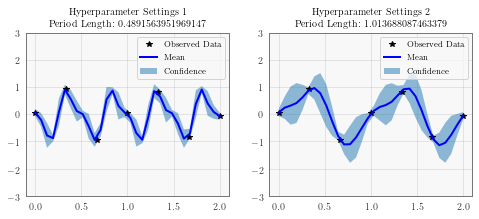

In [8]:
f, axs = plt.subplots(1, 2, figsize=(8, 3))
    
for i, ax in enumerate(axs):
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    ax.plot(test_x.numpy(), means[i].numpy(), 'b')
    ax.fill_between(test_x.numpy(), lowers[i], uppers[i], alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(
        f'Hyperparameter Settings {i + 1}\n'
        f'Period Length: {model.covar_module.base_kernel.period_length[i].squeeze().item()}'
    )